In [58]:
from TradeGenerator import *
import matplotlib.pyplot as plt

In [59]:
file_name="rawTrade.csv"
import os.path
import pandas as pds
numOfClusters=4
trainingDataSize=330

In [60]:
if( os.path.isfile(file_name)  ):
    rawdf = pds.read_csv(file_name)
else:
    t = TradeGenerator()
    tList = t.prepareTradeList(tradingdays=360)
    rawdf = t.tradeListConvert2DataFrame(tList)
    rawdf.to_csv(file_name,index=False)
    

rawdf["total"] = rawdf["price"] * rawdf["quantity"]
df=rawdf

df=df.drop("tradeId",axis=1)

In [61]:
from sklearn.base import BaseEstimator, TransformerMixin
from IPython.core.debugger import set_trace

class CategoryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, attribute): # no *args or **kargs
        self.attribute = attribute
    def fit(self, X):
        return self  # nothing else to do
    def transform(self, X, y=None):
        #set_trace()
        _encoded, _categories = X[self.attribute].factorize()
        self.categoriesIndex = _categories
        X[self.attribute+"_cat"] = _encoded
        X.drop(self.attribute,axis=1 ,inplace=True)
        return X
        

In [62]:
from sklearn.preprocessing import StandardScaler
OrgTypeCategoryEncoder = CategoryEncoder("orgType")
CustCategoryEncoder = CategoryEncoder("cust")
SecCategoryEncoder = CategoryEncoder("secid")
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('OrgType', OrgTypeCategoryEncoder),
        ('Cust', CustCategoryEncoder),
            ('Sec', SecCategoryEncoder)
    ])

In [63]:
newdf=num_pipeline.fit_transform(df)

In [64]:
secIdInx = newdf["secid_cat"]
newdf = newdf.drop("secid_cat",axis=1)

In [65]:
newdf[(newdf["day"]<2) ].head()

,day,price,quantity,total,orgType_cat,cust_cat
0,0,98,5817950,570159100,0,0
1,1,111,8967678,995412258,1,0
360,0,93,3147146,292684578,1,1
361,1,102,9259788,944498376,1,1
720,0,118,3489053,411708254,1,2


In [66]:
trainXdf = newdf[(newdf["day"]<trainingDataSize) ]
trainYdf = newdf[(newdf["day"]>=trainingDataSize)]

In [67]:
trainXdf=trainXdf.drop("day",axis=1)
trainYdf = trainYdf.drop("day",axis=1)

In [68]:
trainYdf.head()

,price,quantity,total,orgType_cat,cust_cat
330,115,8097789,931245735,3,0
331,111,8528840,946701240,3,0
332,115,8997456,1034707440,1,0
333,113,2313493,261424709,3,0
334,104,7727351,803644504,1,0


(row,col)=trainXdf.shape
data = np.zeros((len(CustCategoryEncoder.categoriesIndex),col), dtype=np.float32)
for c in range(len(CustCategoryEncoder.categoriesIndex)):
    custClassSet = trainXdf[ trainXdf["cust_cat"] ==c ]
    
    for j in range(0,col):
        data[c,j] = np.round(np.sum( custClassSet[custClassSet["orgType_cat"]==j]["total"] )/1000000)


In [69]:
def generateFeatures(tradeData,scale,custCategory,includeCount=False):
    (row,col)=tradeData.shape
    numCol = col*2 if includeCount else col
    data = np.zeros((len(custCategory.categoriesIndex),numCol), dtype=np.float32)
    for c in range(len(custCategory.categoriesIndex)):
        custClassSet = tradeData[ tradeData["cust_cat"] ==c ]
        for j in range(0,col):
            data[c,j] = np.round(np.sum( custClassSet[custClassSet["orgType_cat"]==j]["total"] )/scale)
            if(includeCount):
                data[c,j+col] = np.sum( custClassSet[custClassSet["orgType_cat"]==j]["total"].count() )
            
    return data

In [70]:
traindata = generateFeatures(trainXdf,1000000,CustCategoryEncoder,True)
trainLabelData = generateFeatures(trainYdf,1000000,CustCategoryEncoder,False)

In [71]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=numOfClusters, random_state=0).fit(traindata)

In [72]:
ll=pd.DataFrame(kmeans.labels_)

In [73]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

def plot2DCluster(kmeans,data,xaxis,yaxis,axisIndex,subplot=111):
    ll=pd.DataFrame(kmeans.labels_)
    numOfCluster = kmeans.n_clusters
    
    plt.subplot(subplot)
    colors = cm.rainbow(np.linspace(0, 1, numOfCluster))
    for c in range(0,numOfCluster):
        d = data[ll[0]==c]
        plt.scatter(d[:,xaxis],d[:,yaxis],c=colors[c],marker="o")
        plt.scatter(kmeans.cluster_centers_[c,xaxis],kmeans.cluster_centers_[c,yaxis],c=colors[c],marker="x")
        
    # rotate the axes and update
    plt.xlabel(axisIndex[xaxis], fontsize=14)
    plt.ylabel(axisIndex[yaxis], fontsize=14)
    #ax.set_zlabel("restaurant", fontsize=14)
    

def plot3DCluster(kmeans,data,xaxis,yaxis,zaxis,axisIndex):
    ll=pd.DataFrame(kmeans.labels_)
    numOfCluster = kmeans.n_clusters
    
   
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, numOfCluster))
    for c in range(0,numOfCluster):
        d = data[ll[0]==c] #select the data of cluster
        ax.scatter(d[:,xaxis],d[:,yaxis],d[:,zaxis],c=colors[c],marker="o")
        ax.scatter(kmeans.cluster_centers_[c,xaxis],kmeans.cluster_centers_[c,yaxis],kmeans.cluster_centers_[c,zaxis],c=colors[c],marker="x")
        
    # rotate the axes and update
    ax.set_xlabel(axisIndex[xaxis], fontsize=14)
    ax.set_ylabel(axisIndex[yaxis], fontsize=14)
    ax.set_zlabel(axisIndex[zaxis], fontsize=14)
    #plt.show()

In [74]:
OrgTypeCategoryEncoder.categoriesIndex

Index(['airline', 'Gov', 'tech', 'energy', 'restaurant'], dtype='object')

Clustering the past training data.....


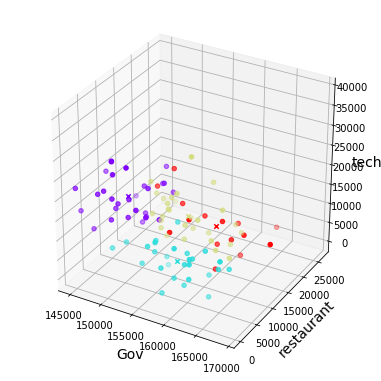

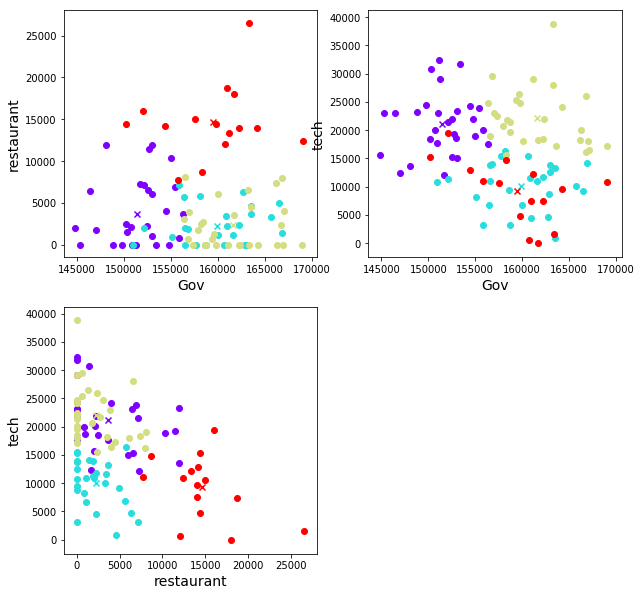

In [75]:
print ("Clustering the past training data.....")
fig = plt.figure(figsize=(5, 5))
plot3DCluster(kmeans,traindata,1,4,2,OrgTypeCategoryEncoder.categoriesIndex)
plt.show()
fig = plt.figure(figsize=(10, 10))
plot2DCluster(kmeans,traindata,1,4,OrgTypeCategoryEncoder.categoriesIndex,221)
plot2DCluster(kmeans,traindata,1,2,OrgTypeCategoryEncoder.categoriesIndex,222)
plot2DCluster(kmeans,traindata,4,2,OrgTypeCategoryEncoder.categoriesIndex,223)
plt.show()

In [76]:
print("Cluster centre:")
cSet=np.round(kmeans.cluster_centers_[:,0:len(OrgTypeCategoryEncoder.categoriesIndex)])
ClusterCenter = pds.DataFrame(cSet, columns=OrgTypeCategoryEncoder.categoriesIndex)
ClusterCenter

Cluster centre:


,airline,Gov,tech,energy,restaurant
0,3417.0,151435.0,21128.0,7347.0,3716.0
1,4136.0,159904.0,10065.0,13265.0,2214.0
2,1895.0,161576.0,22102.0,4758.0,2315.0
3,4031.0,159434.0,9246.0,3449.0,14631.0


In [77]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(traindata, trainLabelData)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [88]:
predictedResult=tree_reg.predict(traindata[0].reshape(1,-1))
RegressionResult = pds.DataFrame(predictedResult, columns=OrgTypeCategoryEncoder.categoriesIndex)
print ( "With a client traded with position in million in the past {0} days".format(trainingDataSize))
print ( "Trade notional in millions:")
pds.DataFrame(traindata[0,0:5].reshape(1,-1), columns=OrgTypeCategoryEncoder.categoriesIndex)

With a client traded with position in million in the past 330 days
Trade notional in millions:


,airline,Gov,tech,energy,restaurant
0,570.0,151077.0,23050.0,12026.0,0.0


In [89]:
print ( "with number of deals:")
pds.DataFrame(np.int32(traindata[0,5:10].reshape(1,-1)), columns=OrgTypeCategoryEncoder.categoriesIndex)

with number of deals:


,airline,Gov,tech,energy,restaurant
0,1,267,42,20,0


In [79]:
print ("Here is the predicted new trade position in million:")
RegressionResult

Here is the results in million:


,airline,Gov,tech,energy,restaurant
0,0.0,12898.0,0.0,5031.0,0.0


In [82]:
XX=pds.DataFrame(traindata[:,0:5], columns=OrgTypeCategoryEncoder.categoriesIndex)
YY=pds.DataFrame(trainLabelData, columns=OrgTypeCategoryEncoder.categoriesIndex)

In [83]:
XX.describe()

,airline,Gov,tech,energy,restaurant
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3261.770020,157862.312500,16641.169922,7609.350098,4541.520020
std,3650.749268,5673.297363,7704.953613,5483.751465,5410.802734
min,0.000000,144806.000000,0.000000,0.000000,0.000000
25%,0.000000,153028.000000,11233.000000,3287.000000,0.000000
50%,2096.500000,158176.000000,16832.500000,6845.000000,2315.000000
75%,5485.750000,162240.250000,22012.500000,11063.500000,6973.000000
max,17618.000000,169055.000000,38832.000000,23091.000000,26537.000000


In [84]:
YY.describe()

,airline,Gov,tech,energy,restaurant
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,285.299988,14308.790039,1569.060059,792.809998,514.599976
std,784.472046,1703.320068,1572.170044,1421.164673,1168.187744
min,0.000000,10588.000000,0.000000,0.000000,0.000000
25%,0.000000,13083.750000,0.000000,0.000000,0.000000
50%,0.000000,14403.000000,1114.000000,0.000000,0.000000
75%,0.000000,15444.750000,2784.000000,1102.000000,251.250000
max,3866.000000,18307.000000,6090.000000,6166.000000,5632.000000
